In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB




# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new


# Processing the data - I
# Preprocessing of training data
def load_and_process_data():
    training_df = pd.read_csv('../data/Training.csv')
    test_df = pd.read_csv('../data/Test.csv')

    proc_training_df = apply_cutoff(preprocess(training_df), 1)

    # Set cutoff to be the label; define data_x and y accordingly
    data_x = proc_training_df.drop('cutoff', axis=1)
    data_y = proc_training_df['cutoff']

    # Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
    r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
    s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
    r_vectorizer.fit(data_x.reviewText)
    s_vectorizer.fit(data_x.summary)

    # Apply TF-IDF vectorization 
    data_x = apply_tfidf(data_x, r_vectorizer, s_vectorizer)

    # Apply robust scaling
    scaler = preprocessing.RobustScaler()
    data_x = pd.DataFrame(scaler.fit_transform(data_x), columns=data_x.columns, index=data_x.index)

    # Let us reduce the number of features by eliminating the statistically least correlated ones.
    relcols = data_x.columns[abs(data_x.corrwith(data_y)) > 0.01]


    # We will go with these columns.
    data_x = data_x[relcols]

    return data_x, data_y

def create_splits(data_x, data_y, n_splits):
    # 5-fold cross validation
    kf = KFold(n_splits=n_splits, shuffle=True)
    splits = []
    for train_idx, val_idx in kf.split(data_x, data_y):
        # Apply split
        x_train, x_val = data_x.iloc[train_idx], data_x.iloc[val_idx]
        y_train, y_val = data_y.iloc[train_idx], data_y.iloc[val_idx]
        
        # Reset indices
        x_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        x_val.reset_index(drop=True, inplace=True)
        y_val.reset_index(drop=True, inplace=True)
        splits.append((x_train, x_val, y_train, y_val))
    return splits



In [3]:

X_DATA, Y_DATA = load_and_process_data()

test_splits = create_splits(X_DATA, Y_DATA, 5)

print(len(test_splits[0][1]), len(X_DATA))

5838 29189


# Define and create the population data

In [7]:
Q_MEAN = 0.5
EPOCH = 2
POPULATION_SIZE = 10000
TRAIN_DIM = 100
STEP = 1

In [5]:
import numpy as np

def initialize_with_str_seed(init_str):
    """
    Initializes random number generator with seed corresponding to given input string init_str.
    :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                     values of each character in init_str.
    """
    rnd_val = 0
    if init_str:
        for c in init_str:
            rnd_val += ord(c)
    np.random.seed(rnd_val)

def gen_data(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

def gen_valid(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    
    n = int(n/10)
    
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

In [8]:
x_population, y_population = gen_data(POPULATION_SIZE, TRAIN_DIM)
x_valid, y_valid = gen_data(int(POPULATION_SIZE/500), TRAIN_DIM)

# Define the evaluation functions

In [12]:
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGaussianNB, MechanizedLogisticRegression, MechanizedOneVSRest, MechanizedDecisionTree
from mechanism.mechanized_models import MechanizedGridSearchCV

def hyper_parameter(splits):
    x_train, x_val, y_train, y_val = splits[0]
    estimator = MechanizedLogisticRegression(max_iter=1500)
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    gs_cls = MechanizedOneVSRest(estimator = estimator)
    gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

    params_LR = {'estimator__C': np.logspace(-0.2, 0.7, num = 10)}
    gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv = 2, verbose=2, scoring='f1_macro')
    gs_LR.fit(x_train, y_train)


BEST_C = 1.5848931924611134
'''
C=1.5848931924611134, max_iter=1500
'''

def eval(train_size, estimator, mechanism):
    # f1_scores, acc_scores, models = [], [], [], [], []
    x_train, y_train = x_population[:train_size], y_population[:train_size]
    estimator = estimator
    
    model = MechanizedOneVSRest(estimator, mechanism = mechanism)
    # model.choose_mechanism(mechanism)

    model.fit(x_train, y_train)
    # Predict
    y_pred = model.predict(x_valid)

    return mean_squared_error(y_valid, y_pred)


def eval_multiple_rounds(stepped_rounds, mechanism, non_adaptive_num):
    generalization_error_list = []
    for r in stepped_rounds:
        estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = r, mechanism = mechanism, solver = 'sag')
        generalization_error_list.append(eval(non_adaptive_num, estimator, mechanism))
    return generalization_error_list

def eval_const_rounds(round, mechanism, stepped_non_adaptive_num):
    generalization_error_list = []
    for train_size in stepped_non_adaptive_num:
        estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = round, mechanism = mechanism)
        generalization_error_list.append(eval(train_size, estimator, mechanism))
    return generalization_error_list

# Evaluate the O(n) Adaptivity program

In [ ]:

baseline_generalization_error_list = eval_multiple_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), stepped_non_adaptive_num)
# baseline_generalization_error_list = [0.47190818773552584, 0.473107228502912, 0.473792394655704, 0.47070914696813976, 0.4659129838985954, 0.4720794792737239, 0.47447756080849607, 0.473107228502912, 0.4775608084960603, 0.47619047619047616, 0.4712230215827338, 0.47447756080849607, 0.47567660157588215, 0.473792394655704, 0.47533401849948614]
print(baseline_generalization_error_list)

# Evaluation the O(1) adaptivity program

In [16]:

def plot_error(rounds, generalization_error, mechanism):
    plt.plot(rounds, generalization_error, label = mechanism)
    plt.xlabel("Queries")
    plt.ylabel("RMSE (Generalization Error) for adaptive queries")
    plt.legend()
    plt.grid()

stepped_non_adaptive_num = range(100, 1000, 10)
round = 5


In [ ]:

baseline_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), stepped_non_adaptive_num)
# baseline_generalization_error_list = [0.47190818773552584, 0.473107228502912, 0.473792394655704, 0.47070914696813976, 0.4659129838985954, 0.4720794792737239, 0.47447756080849607, 0.473107228502912, 0.4775608084960603, 0.47619047619047616, 0.4712230215827338, 0.47447756080849607, 0.47567660157588215, 0.473792394655704, 0.47533401849948614]
print(baseline_generalization_error_list)

In [ ]:
gaussian_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.1), stepped_non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(gaussian_generalization_error_list)


In [ ]:
threshold_generalization_error_list = eval_const_rounds(round, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.5, hold_frac = 0.5, threshold = 0.8), stepped_non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)

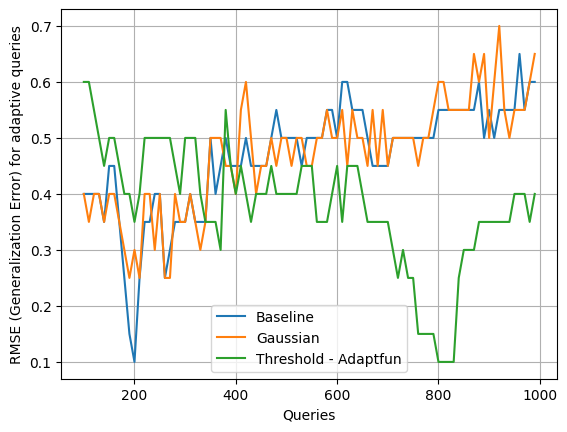

In [25]:
import math

plt.figure()
x_range = stepped_non_adaptive_num
plot_error(x_range, (baseline_generalization_error_list), "Baseline")
plot_error(x_range, (gaussian_generalization_error_list), "Gaussian")
plot_error(x_range, (threshold_generalization_error_list), "Threshold - Adaptfun")
plt.show()

# Evaluate the O(n*m) Adaptivity Program

In [29]:
def create_splits(data_x, data_y, n_splits):
    # 5-fold cross validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state = np.random.randint(1000000))
    splits = []
    for train_idx, val_idx in kf.split(data_x, data_y):
        # Apply split
        x_train, x_val = data_x.iloc[train_idx], data_x.iloc[val_idx]
        y_train, y_val = data_y.iloc[train_idx], data_y.iloc[val_idx]
        
        # Reset indices
        x_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        x_val.reset_index(drop=True, inplace=True)
        y_val.reset_index(drop=True, inplace=True)
        splits.append((x_train, x_val, y_train, y_val))
    return splits

In [79]:
def eval(r, mechanism, splits):
    # f1_scores, acc_scores, models = [], [], [], [], []
    x_train, x_val, y_train, y_val = splits[0]
    # estimator = estimator

    estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = r, mechanism = mechanism, solver = 'lbfgs', random_state = np.random.randint(1000000))
    model = MechanizedOneVSRest(estimator, mechanism = mechanism)
    # model.choose_mechanism(mechanism)
    train_size = int(len(x_train)/2)
    model.fit(x_train[:train_size], y_train[:train_size])
    # Predict
    _, x_val, _, y_val = create_splits(X_DATA, Y_DATA, 2)[1]
    model.choose_mechanism(Mechanism(mechanism_type = Mechanism.MechanismType.NONE))
    y_pred = model.predict(x_val)

    return mean_squared_error(y_val, y_pred)

In [66]:
def eval_multiple_rounds(stepped_rounds, mechanism, non_adaptive_num):
    splits = create_splits(X_DATA, Y_DATA, non_adaptive_num)
    generalization_error_list = []
    for r in stepped_rounds:
        generalization_error_list.append(eval(r, mechanism, splits))
    return generalization_error_list

In [60]:
stepped_rounds = range(100, 500, 50)
non_adaptive_num = 5

In [ ]:
baseline_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), non_adaptive_num)
baseline_generalization_error_list = [0.47190818773552584, 0.473107228502912, 0.473792394655704, 0.47070914696813976, 0.4659129838985954, 0.4720794792737239, 0.47447756080849607, 0.473107228502912, 0.4775608084960603, 0.47619047619047616, 0.4712230215827338, 0.47447756080849607, 0.47567660157588215, 0.473792394655704, 0.47533401849948614]

gaussian_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.03), non_adaptive_num)
gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]


In [82]:
gaussian_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.003), non_adaptive_num)


in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression


In [83]:
print(np.sqrt(gaussian_generalization_error_list))

[0.41735018 0.41595229 0.40989542 0.41413626 0.41430168 0.41430168
 0.41488014 0.40972821]


In [74]:
print(np.sqrt(baseline_generalization_error_list))

[0.3416018  0.3457885  0.34069796 0.33542807 0.33948909 0.33224664
 0.34658023 0.34360183]


In [73]:
baseline_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), non_adaptive_num)


in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression


In [15]:
print(baseline_generalization_error_list)

[0.08821514217197671, 0.08821514217197671, 0.08821514217197671, 0.08821514217197671, 0.08821514217197671]


In [ ]:
gaussian_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.1), non_adaptive_num)


In [24]:
print(gaussian_generalization_error_list)

[0.17882836587872558, 0.17934224049331962, 0.17831449126413154, 0.1778006166495375, 0.1774580335731415, 0.17865707434052758, 0.17882836587872558, 0.17814319972593354, 0.17797190818773553, 0.17865707434052758, 0.1789996574169236, 0.1789996574169236, 0.17865707434052758, 0.17865707434052758, 0.17797190818773553]


In [ ]:
threshold_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.5, hold_frac = 0.5, threshold = 0.8), non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)

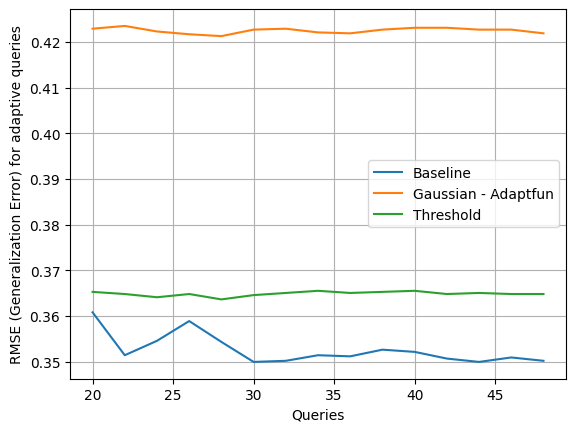

In [29]:
plt.figure()
x_range = stepped_rounds
plot_error(x_range, np.sqrt(baseline_generalization_error_list), "Baseline")
plot_error(x_range, np.sqrt(gaussian_generalization_error_list), "Gaussian - Adaptfun")
plot_error(x_range, np.sqrt(threshold_generalization_error_list), "Threshold")
plt.show()

# Evaluate the O(n) Adaptivity Program

In [29]:
def eval_multiple_rounds(stepped_rounds, mechanism, non_adaptive_num):
    generalization_error_list = []
    for r in stepped_rounds:
        estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = r, mechanism = mechanism, solver = 'sag')
        generalization_error_list.append(eval(non_adaptive_num, estimator, mechanism))
    return generalization_error_list

def eval_const_rounds(round, mechanism, stepped_non_adaptive_num):
    generalization_error_list = []
    for train_size in stepped_non_adaptive_num:
        estimator = MechanizedLogisticRegression(C = BEST_C, max_iter = round, mechanism = mechanism)
        generalization_error_list.append(eval(train_size, estimator, mechanism))
    return generalization_error_list

In [34]:
stepped_rounds = range(500, 1000, 100)
non_adaptive_num = 100



In [39]:

baseline_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.NONE), non_adaptive_num)


in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression
in Baseline Mechanized One v.s. Rest
in Baseline Logistic Regression


In [40]:
gaussian_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.GAUSSIAN, sigma = 0.08), non_adaptive_num)


in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
[[ 1.1867531  -1.04428614  1.22860698 ...  0.91323106  1.06479415
   1.1785098 ]
 [-0.88482466  0.88646807  0.92705423 ...  1.34600627 -0.77076904
  -0.81071823]
 [-0.77915403 -1.213966    0.96924482 ...  0.92300815 -1.2001019
   0.92400496]
 ...
 [-0.99518829 -0.78744571  1.10660287 ... -1.09866198 -1.28089146
  -1.2377298 ]
 [ 0.9804446   0.9421234  -1.03139228 ... -1.10199381 -1.06851614
  -0.9126782 ]
 [ 1.10233637 -0.95236872  1.02261626 ...  1.04137225  0.87403551
   1.02186752]]
in Gaussian Mechanized One v.s. Rest
in gaussian Mechanized Logistic Regression
[[ 0.92810792 -1.07729028  0.951247   ...  0.95279284  0.99530503
   1.301434  ]
 [-0.8754439   1.13311493  0.81556912 ...  1.08824188 -0.89911605
  -0.91401733]
 [-1.06034151 -0.9398956   0.91356771 ...  1.10091813 -1.07050783
   1.18197497]
 ...
 [-0.9340231  -1.0552693   1.17620844 ... -1.08382562 -1.11920889
  -0.99184063]
 [ 1.03282491  1.050

In [41]:
threshold_generalization_error_list = eval_multiple_rounds(stepped_rounds, Mechanism(mechanism_type = Mechanism.MechanismType.THRESHOLD, sigma = 0.08, hold_frac = 0.5, threshold = 0.8), non_adaptive_num)
# gaussian_generalization_error_list = [0.3984241178485783, 0.4035628639945187, 0.39482699554642003, 0.3977389516957862, 0.3977389516957862, 0.3917437478588558, 0.3975676601575882, 0.39585474477560806, 0.38866050017129156, 0.3970537855429942, 0.39568345323741005, 0.3857485440219253, 0.38506337786913325, 0.39157245632065774, 0.3871188763275094]

print(threshold_generalization_error_list)

in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
in Threshold Mechanized One v.s. Rest
in Threshold Mechanized Logistic Regression
in Threshold Mechanized Logistic Regression
[0.6, 0.6, 0.6, 0.6, 0.6]


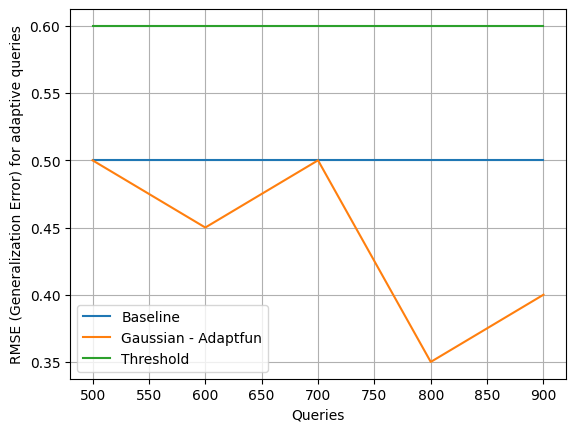

In [42]:
plt.figure()
x_range = stepped_rounds
plot_error(x_range, baseline_generalization_error_list, "Baseline")
plot_error(x_range, gaussian_generalization_error_list, "Gaussian - Adaptfun")
plot_error(x_range, threshold_generalization_error_list, "Threshold")
plt.show()
